In [1]:
# IMPORTS
import qiskit
import matplotlib as mpl
import numpy as np

In [2]:
n = 2 # number of bits in address
m = 3 # number of bits in data

address = qiskit.QuantumRegister(size=n,name="address")
auxiliary = qiskit.QuantumRegister(size=2**n,name="auxiliary")
memory = qiskit.QuantumRegister(size=(2**n)*m,name="memory")
output = qiskit.QuantumRegister(size=m,name="output")
c_output = qiskit.ClassicalRegister(size=m,name="c_output")


In [3]:
circuit = qiskit.QuantumCircuit(address,auxiliary,memory,output,c_output)
circuit.x(auxiliary[0])

In [4]:
def fanout_to_auxiliary(circuit,address,auxiliary):
    circuit.barrier()
    circuit.barrier()
    
    for i in range(address.size):
        for ii in range(2**i):
            circuit.toffoli(address[i],auxiliary[ii],auxiliary[ii+(2**i)])
            circuit.cx(auxiliary[ii+(2**i)],auxiliary[ii])
    
    circuit.barrier()
    return circuit

In [5]:
def read_from_memory(circuit,auxiliary,memory,output):
    circuit.barrier()
    for i in range(2**n):
        for output_bit in range(m):

            circuit.toffoli(auxiliary[i],memory[output_bit+(m*i)],output[output_bit])
        circuit.barrier()

    circuit.barrier()
    return circuit

In [6]:
def search(circuit,address,location):
    for bit in range(len(location)):
        if location[bit] == '1':
            circuit.x(address[bit])

    return circuit

In [7]:
# still working on creating custom superpositions of addresses in order to retrieve in superposition

def vec_to_superposition_gate(vec):
    unitary = np.zeros(2**n)
    for num in range(len(vec)):
        unitary[num] = 1
    return unitary

def determine_constant(qbit_list):
    if sum(qbit_list) == 0: # always zero
        return 0
    elif sum(qbit_list) == len(qbit_list): # always one
        return 1
    else: 
        return 'Both'

def super_search(circuit,address,location):
    print(super_search)
    statevec = vec_to_superposition_gate(location)
    statevec/=np.linalg.norm(statevec)
    statevec = qiskit.quantum_info.Statevector(statevec)

    temp_circ = qiskit.QuantumCircuit(len(address))
    print(statevec)
    temp_circ.initialize(statevec)
    temp_circ = qiskit.transpile(temp_circ, optimization_level=1)
    print(circ)
    gate = temp_circ.to_gate()
    circuit.unitary(gate)
    return circuit

In [8]:
def extract(circuit,location):
    if type(location) == str:
        circuit = search(circuit,address,location)
    elif type(location) == list:
        circuit = super_search(circuit,address,location)
    circuit = fanout_to_auxiliary(circuit,address,auxiliary)
    circuit = read_from_memory(circuit,auxiliary,memory,output)
    circuit.measure(output,c_output)
    return circuit

In [9]:
def simulate(circuit):
    simulator = qiskit.Aer.get_backend('qasm_simulator') #access Aer  Simulator
    job = qiskit.execute(circuit,simulator,shots=1,memory=True)
    result = job.result()
    return result.get_memory()

In [10]:
def store(circuit,data,location):
    if type(data) == str:
        for bit in range(len(data)):
            if data[bit] == '1':
                circuit.x(memory[(location*m)+bit])
        return circuit
    elif type(data) == list:
        for i in range(len(data)):
            circuit = store(circuit,data[i],i)

        return circuit

In [11]:
circuit = store(circuit,['110','011','010','101'],'01')

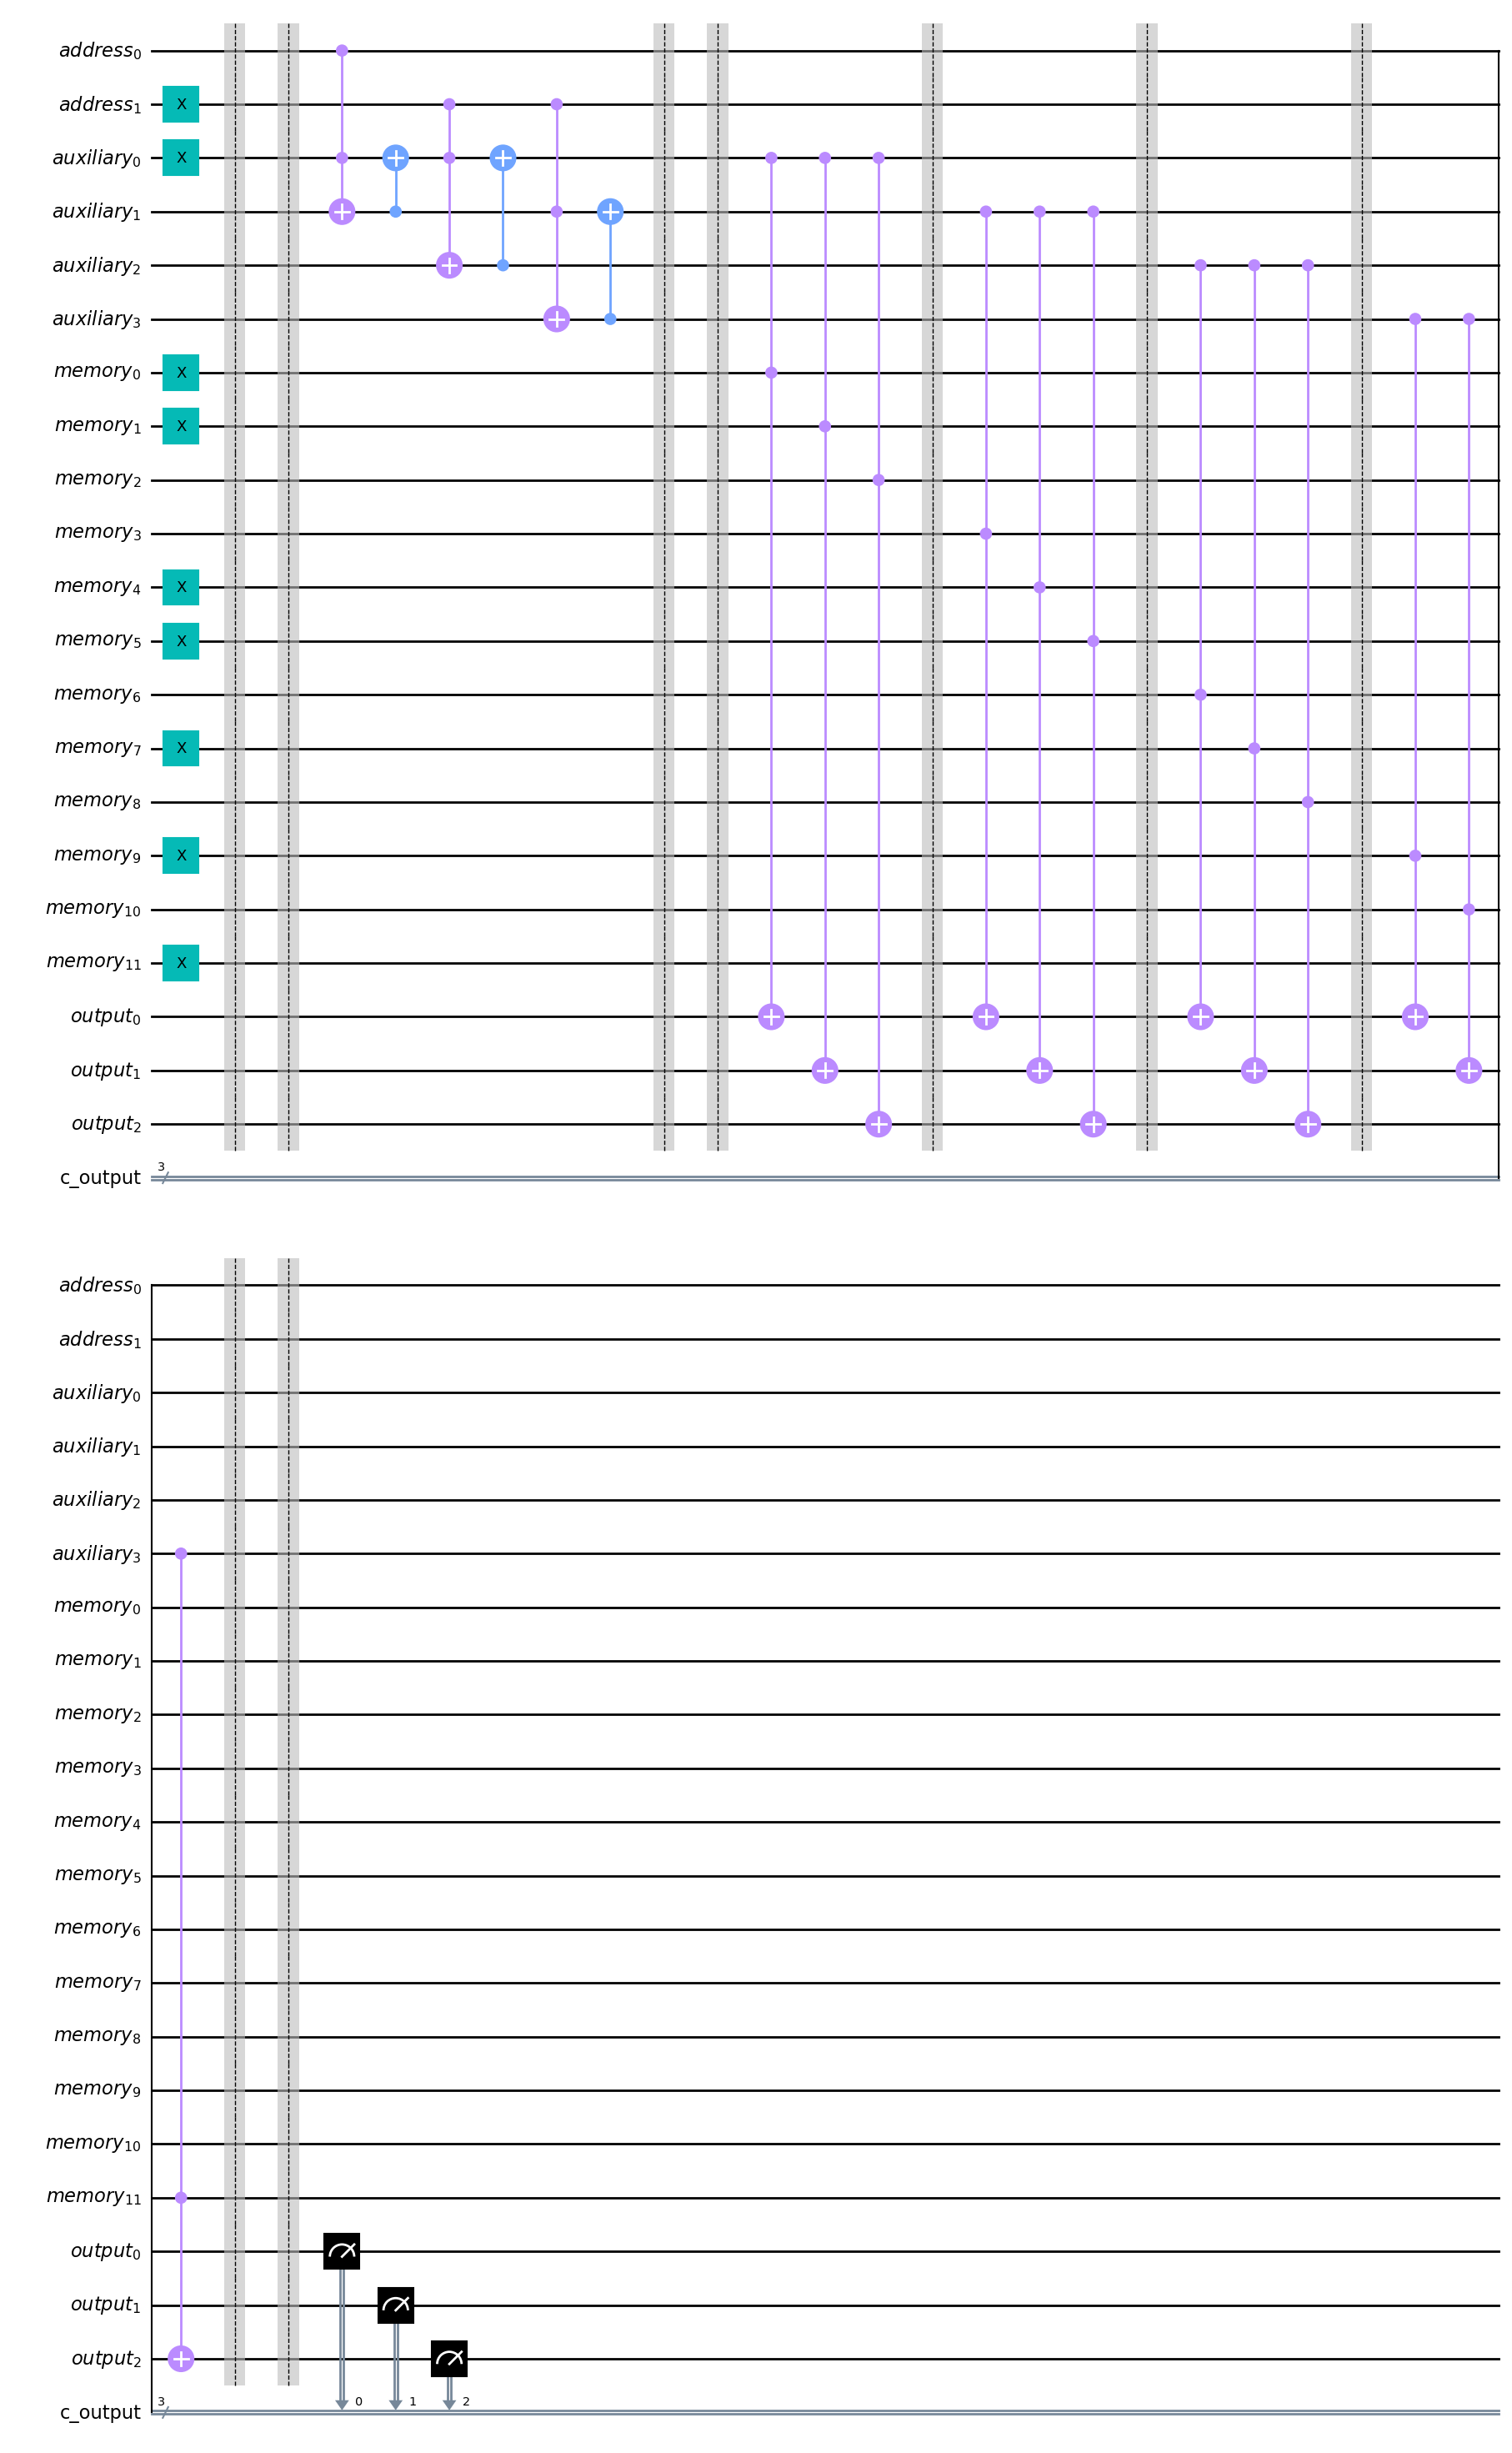

In [12]:
circuit = extract(circuit,'01')
circuit.draw(output='mpl')

In [13]:
print(simulate(circuit))

['010']


In [ ]:
# TODO: Create Oracle using Toffoli to detect if two neighbouring qubits are in the same state or not. If not, the Oracle flips that superposition to a negative amplitude.
# Create Diffuser following my article: https://medium.com/quantum-untangled/grovers-algorithm-mathematics-circuits-and-code-quantum-algorithms-untangled-c4aa47d506e5


from math import pi,sqrt,floor

iterations = floor((pi/4)*sqrt(n)) #formula for number of iterations

for _ in range(iterations):
    circuit = Oracle(circuit,n,hidden_bits)
    circuit = Diffuser(circuit,n) #Amplitude Amplification

circuit.barrier()

In [ ]:
# after repeating, measure, and the 'correct' answers that the Oracle flipped present themselves